# Power Outages
* **See the main project notebook for instructions to be sure you satisfy the rubric!**
* See Project 03 for information on the dataset.
* A few example prediction questions to pursue are listed below. However, don't limit yourself to them!
    * Predict the severity (number of customers, duration, or demand loss) of a major power outage.
    * Predict the cause of a major power outage.
    * Predict the number and/or severity of major power outages in the year 2020.
    * Predict the electricity consumption of an area.

Be careful to justify what information you would know at the "time of prediction" and train your model using only those features.

# Summary of Findings


### Introduction
I think we should try to predict outage duration

### Baseline Model
TODO

### Final Model
TODO

### Fairness Evaluation
TODO

# Code

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.base import BaseEstimator, TransformerMixin



%matplotlib inline
%config InlineBackend.figure_format = 'retina'  # Higher resolution figures

In [47]:
#importing data and putting it into the correct format
data = pd.read_excel('outage.xlsx')

data = data.drop(index=[0,1,2,3,5], axis=0)
new_header = data.iloc[0]
data = data[1:]
data.columns = new_header
data = data.drop(labels='variables', axis=1)
data = data.reset_index()

### Baseline Model

In the baseline model I will attempt to classify the cause of power outages using just the base (non transformed) variables). All the variables selected, as listed in the following cell, seem like they would be the most closely related with the cause of the power outage. The data is cleaned before the model is made.

In [48]:
subset = data[['CAUSE.CATEGORY', 'OUTAGE.DURATION','POSTAL.CODE', 'TOTAL.CUSTOMERS', 'MONTH', 'PC.REALGSP.STATE', 'UTIL.CONTRI', 'AREAPCT_URBAN', 'ANOMALY.LEVEL', 'CLIMATE.REGION','TOTAL.SALES']]

In [4]:
len(data)

1534

First let's take a look at how many null values are in our columns of interest

In [5]:
subset.isnull().sum()

4
CAUSE.CATEGORY       0
OUTAGE.DURATION     58
POSTAL.CODE          0
TOTAL.CUSTOMERS      0
MONTH                9
PC.REALGSP.STATE     0
UTIL.CONTRI          0
AREAPCT_URBAN        0
ANOMALY.LEVEL        9
CLIMATE.REGION       6
TOTAL.SALES         22
dtype: int64

In [ ]:
We can first use probabilistic imputation to fill the null values in the numeric variables

In [49]:
#filling null values of numeric variables with probabilistic imputation
columns_with_nulls = ['OUTAGE.DURATION', 'ANOMALY.LEVEL', 'TOTAL.SALES']

for col in columns_with_nulls:
    num_null = subset[col].isnull().sum()
    fills = subset[col].dropna().sample(num_null, replace = True)
    fills.index = subset.loc[subset[col].isnull()].index
    subset = subset.fillna({col:fills.to_dict()})



The observations with null values in the categorical variables are just dropped

In [50]:
#dropping rows with null values in categorical variables
subset = subset.dropna()

Pipeline that applies one hot encoder to postal code and climate region. Then uses K nearest neighbors classifier 

In [51]:
ct = ColumnTransformer(
    [
        ('ohe', OneHotEncoder(handle_unknown = 'ignore'), ['POSTAL.CODE', 'CLIMATE.REGION']),
    ])
pl = Pipeline(steps = [
            ('columntrans', ct),
            ('knn',  KNeighborsClassifier(n_neighbors = 5))
            ])

Let's see how accurate the base model is using 400 train-test-split iterations

In [54]:
#finding average average accuracy

accuracies = []
for i in range(400):
    y = subset['CAUSE.CATEGORY']
    x = subset.drop('CAUSE.CATEGORY', axis=1)
    x_train, x_test, y_train, y_test = train_test_split(x, y)
    pl.fit(x_train, y_train)
    accuracies.append(accuracy_score(y_test, pl.predict(x_test)))

This is the proportion of cause categories correctly classified

In [55]:
pd.Series(accuracies).mean()

0.540921052631579

Is this good? Let's compare it to the accuracy from randomly guessing

In [52]:
accuracies = []
for i in range(400):
    #The 0.25 is because train_test_split uses 0.25 of the data for testing as default
    guesses = subset['CAUSE.CATEGORY'].sample(n = int(0.25*len(subset)), replace = True)
    
    y = subset['CAUSE.CATEGORY']
    x = subset.drop('CAUSE.CATEGORY', axis=1)
    x_train, x_test, y_train, y_test = train_test_split(x, y)
    accuracies.append(accuracy_score(y_test, guesses))

In [53]:
pd.Series(accuracies).mean()

0.3344934210526317

looks like our base model is better than randomly guessing!

### Final Model

First, let's determine the optimal number of neighbors to classify on. In the baseline model we only used 5.

In [11]:
y = subset['CAUSE.CATEGORY']
x = subset.drop('CAUSE.CATEGORY', axis=1)
x_train, x_test, y_train, y_test = train_test_split(x, y)

In [12]:
parameters = {
    'knn__n_neighbors': [i for i in range(1,51)]
}

In [13]:
ct = ColumnTransformer(
    [
        ('ohe', OneHotEncoder(handle_unknown = 'ignore'), ['POSTAL.CODE', 'CLIMATE.REGION']),
    ])
pl = Pipeline(steps = [
            ('columntrans', ct),
            ('knn',  KNeighborsClassifier())
            ])

In [14]:
clf = GridSearchCV(pl, parameters, cv = 5)

In [15]:
clf.fit(x_train, y_train)

C:\Users\ianma\Downloads\anaconda\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('columntrans', ColumnTransformer(n_jobs=None, remainder='drop', sparse_threshold=0.3,
         transformer_weights=None,
         transformers=[('ohe', OneHotEncoder(categorical_features=None, categories=None,
       dtype=<class 'numpy.float64'>, handle_unknown='ignore',
       n_values=Non...ki',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform'))]),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'knn__n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [16]:
best_k = clf.best_params_['knn__n_neighbors']

In [17]:
best_k

25

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000024CC2ED9BA8>]],
      dtype=object)

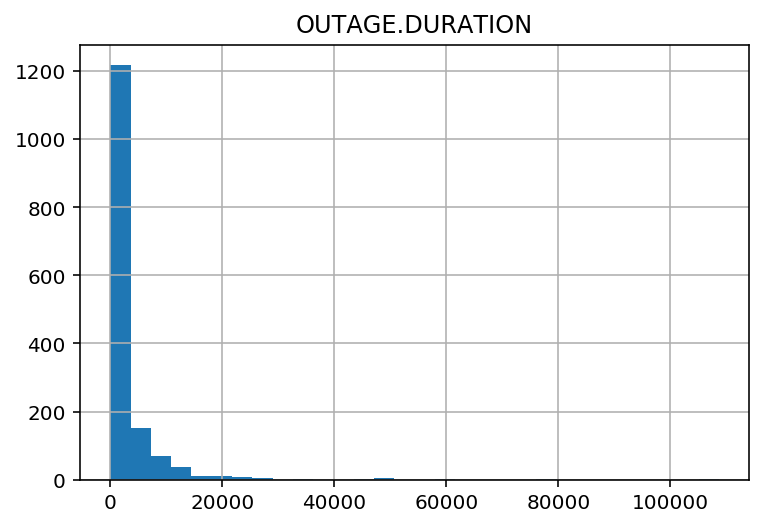

In [60]:
#outliers
subset.hist(column = 'OUTAGE.DURATION', bins = 30)

In [61]:
max(subset['OUTAGE.DURATION'])

108653.0

In [62]:
sum(subset['OUTAGE.DURATION']>20000)

30

In [18]:
subset = subset[(subset['OUTAGE.DURATION'] <= 20000)]

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000024CC2EE3D68>]],
      dtype=object)

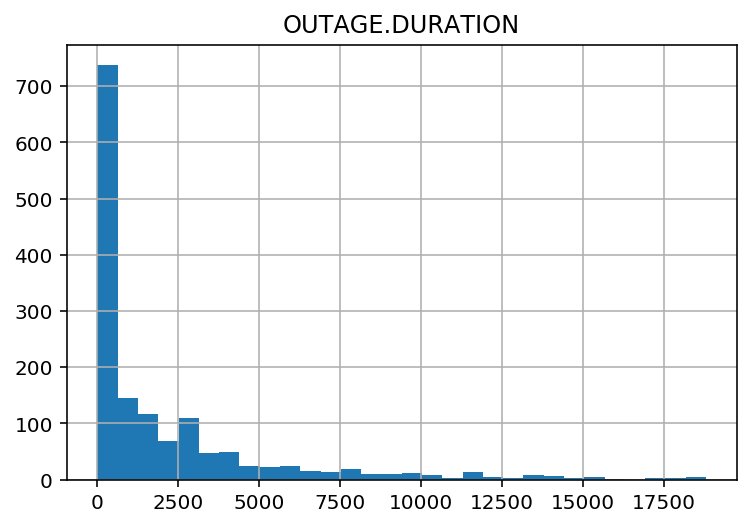

In [64]:
subset.hist(column = 'OUTAGE.DURATION', bins = 30)

In [ ]:
#scale anomoly level by climate region
#month is nominal so we should change that to string and do OHE
#maybe remove outliers

In [19]:


class StdScalerByGroup(BaseEstimator, TransformerMixin):
    
    def __init__(self):
        pass

    def fit(self, X, y=None):
        # X may not be a pandas dataframe (e.g. a np.array)
        df = pd.DataFrame(X)
        
        # A dictionary of means/standard-deviations for each column, for each group.
        
        #use X.columns[0] since groups are always in first column
        agg = df.groupby(X.columns[0]).agg(['mean', 'std'])

        self.grps_ = agg.to_dict()

        return self

    def transform(self, X, y=None):

        try:
            getattr(self, "grps_")
        except AttributeError:
            raise RuntimeError("You must fit the transformer before tranforming the data!")
        

        # Define a helper function here?
        def z_helper(series):
            #we need column name and group. How to access?
            #to get the group name use series.name
            group_name = series.name
            series = series.set_index(series.columns[0])
            def standardize(col):
                mean = self.grps_[(col.name, 'mean')][group_name]
                std = self.grps_[(col.name, 'std')][group_name]
                standardized = (col - mean) / std
                return standardized

            return series.apply(standardize)
            
        
        # X may not be a dataframe (e.g. np.array)

        df = pd.DataFrame(X)
        
        return df.groupby(df.columns[0]).apply(z_helper)
        

In [20]:
def to_string(x):
        return pd.DataFrame(x).astype(str)
num_to_str = FunctionTransformer(func = to_string, validate=False)

month_trans = Pipeline(steps = [
            ('to_string', num_to_str),
            #added categories='auto' to silence warning message
            #handle_unknown incase there are unseen values in the test set
            ('ohe', OneHotEncoder(handle_unknown = 'ignore', categories='auto'))
            ])

ct = ColumnTransformer(
    [
        ('ohe', OneHotEncoder(handle_unknown = 'ignore', categories='auto'), ['POSTAL.CODE', 'CLIMATE.REGION']),
        ('std', StdScalerByGroup(), ['CLIMATE.REGION','ANOMALY.LEVEL']),
        ('month_trans', month_trans, ['MONTH'])
        
    ])
pl = Pipeline(steps = [
            ('columntrans', ct),
            ('knn',  KNeighborsClassifier(n_neighbors = best_k))
            ])

In [21]:
#finding average average accuracy

accuracies = []
for i in range(400):
    y = subset['CAUSE.CATEGORY']
    x = subset.drop('CAUSE.CATEGORY', axis=1)
    x_train, x_test, y_train, y_test = train_test_split(x, y)
    pl.fit(x_train, y_train)
    accuracies.append(accuracy_score(y_test, pl.predict(x_test)))

In [22]:
pd.Series(accuracies).mean()

0.6031951871657754

### Fairness Evaluation

In [30]:
income_cutoff = subset['PC.REALGSP.STATE'].median()

In [29]:
#create boolean variable
subset['low_income'] = subset['PC.REALGSP.STATE'] < income_cutoff

In [39]:
def get_accuracy(df):
    accuracies = []
    for i in range(10):
        y = subset['CAUSE.CATEGORY']
        x = subset.drop('CAUSE.CATEGORY', axis=1)
        x_train, x_test, y_train, y_test = train_test_split(x, y)
        pl.fit(x_train, y_train)
        accuracies.append(accuracy_score(y_test, pl.predict(x_test)))
    return pd.Series(accuracies).mean()

In [40]:
high_income = subset[subset['PC.REALGSP.STATE'] >= income_cutoff]
low_income = subset[subset['PC.REALGSP.STATE'] < income_cutoff]

#calculate observed statistic
#it will be the difference bewteen the stat for the high income and low income

observed_stat = get_accuracy(high_income) - get_accuracy(low_income)

In [41]:
observed_stat

0.005347593582887722

In [42]:
gen_stats = []
for i in range(100):  
    #shuffle column of interest
    shuffled_col = (
        subset['PC.REALGSP.STATE']
        .sample(replace = False, frac=1)
        .reset_index(drop=True)
    )

    #assign shuffled column to original dataframe
    shuffled_df = (
        subset.assign(**{
            'PC.REALGSP.STATE':shuffled_col,
        })
    )
    #calculate statistic
    high_income = shuffled_df[shuffled_df['PC.REALGSP.STATE'] >= income_cutoff]
    low_income = shuffled_df[shuffled_df['PC.REALGSP.STATE'] < income_cutoff]
    
    gen_stats.append(get_accuracy(high_income) - get_accuracy(low_income))

p value = 0.73


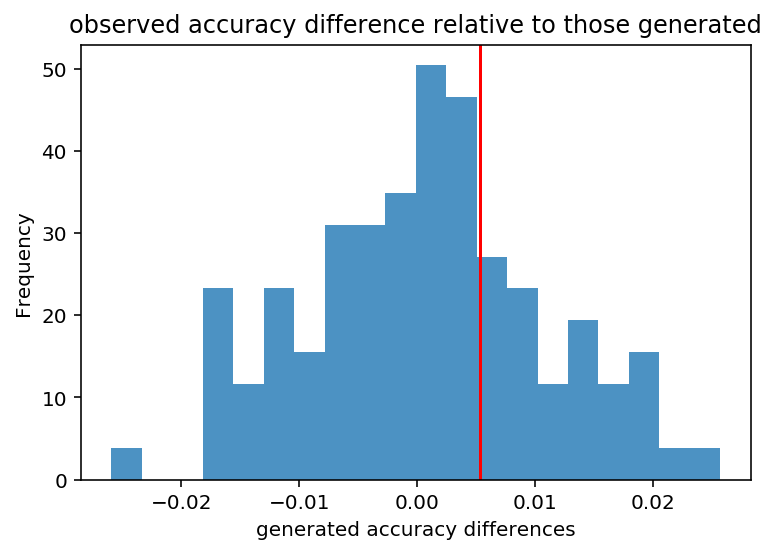

In [44]:
pd.Series(gen_stats).plot(kind='hist', density=True, alpha = 0.8, bins=20)
plt.xlabel("generated accuracy differences")
plt.title("observed accuracy difference relative to those generated")
plt.axvline(x=observed_stat, color='red')

print('p value = ' + str(np.mean(pd.Series(gen_stats) <= observed_stat)))

The model is fair between different income states